In [77]:
from __future__ import division

import os
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
#import xgboost as xgb
#from xgboost.sklearn import XGBClassifier #this is the SKlearn wrapper
from sklearn import neighbors, linear_model
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import roc_curve, auc

import scipy.io as sio

### Helper fcns

In [78]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, norm=True):

    if norm:
        totals = cmat.sum(axis=1)
        totals = totals.T
        totals = np.expand_dims(totals,axis=1)
        totals = np.tile(totals,(1,2))
        cmat_norm = cmat/totals
        print(cmat_norm)
        cm = cmat_norm

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Non-Fall','Fall'], rotation=45)
    plt.yticks(tick_marks, ['Non-Fall','Fall'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [79]:
def LOSOCV(X,y,data):

    AUC_all=[]; fpr_all=[]; tpr_all=[]; Sens_all=[]; Spec_all=[]
    thr = np.linspace(0,1,21)
    thr = thr[::-1]

    plt.figure(figsize=(8,6))

    TTPR_all, TFPR_all = [], []
    
    for train_index, test_index in subj.split(X, y, groups):
        Dtr = data.iloc[train_index]
        Dte = data.iloc[test_index]
        
        SensT, SpecT = ThresholdClass(Dtr,Dte)
        TTPR_all.append(SensT)
        TFPR_all.append(1-SpecT)
        
        Xtr, Xte = X[train_index], X[test_index]
        ytr, yte = y[train_index], y[test_index]
        
        #selct features
        Xtr, Xte = Xtr[:,indmax], Xte[:,indmax]

        forest = RandomForestClassifier(n_estimators=50,random_state=10,warm_start=False)    
        forest.fit(Xtr,ytr)
        ypred = forest.predict(Xte)
        yscore = forest.predict_proba(Xte)
        yscore = yscore[:,1]

        #acc = np.sum(ypred==yte)/len(ypred)
        #print('Acc = %.4f')%acc

    #    fpr, tpr, thresholds = metrics.roc_curve(yte, yscore, pos_label=1,drop_intermediate=False
        #compute ROC at fixed fpr (to plot error bars)
        fpr=np.linspace(0,1,101); tpr=[]
        nscores = np.sort(np.column_stack((yscore[yte==0],yte[yte==0])),axis=0)
        neg_counts = sum(yte==0)
        for f in fpr:
            ind = neg_counts-int(neg_counts*f)-1
            t = (nscores[ind])[0]
            if f==1:
                t = 0
            tpr_t = sum(yscore[yte==1]>t) / sum(yte==1)
            tpr.append(tpr_t) 

        t=.5
        #compute Sens and Spec
        Sens = sum((ypred==1) & (yte==1)) / sum(yte==1); Spec = 1-sum((ypred==1) & (yte==0)) / sum(yte==0)

        fpr = np.asarray(fpr); tpr = np.asarray(tpr)
        roc_auc = auc(fpr, tpr)
        print('AUC = %.4f, Sens = %.4f, Spec = %.4f'%(roc_auc,Sens,Spec))    
        AUC_all.append(roc_auc)
        tpr_all.append(tpr); fpr_all=fpr;
        Sens_all.append(Sens); Spec_all.append(Spec)

        #plot each individual ROC
    #     lw = 2
    #     plt.plot(fpr, tpr, color='darkorange',
    #              lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
    #     plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

    # plt.xlim([-0.05, 1.0])
    # plt.ylim([0.0, 1.05])
    # plt.xlabel('False Positive Rate')
    # plt.ylabel('True Positive Rate')
    # plt.title('Healthy-Healthy')
    #plt.legend(loc="lower right")

    #summary results
    print(('mean AUC = %.3f (+/- %0.3f)')%(np.mean(AUC_all),2*np.std(AUC_all)))
    print(('mean Sens = %.3f (+/- %0.3f)')%(np.mean(Sens_all),2*np.std(Sens_all)))
    print(('mean Spec = %.3f (+/- %0.3f)')%(np.mean(Spec_all),2*np.std(Spec_all)))

    return AUC_all, fpr_all, tpr_all, Sens_all, Spec_all, TTPR_all, TFPR_all

In [80]:
def EvaluateBySubject(Xtr,ytr,Dtr,X,Y,D):

    AUC_all=[]; fpr_all=[]; tpr_all=[]; Sens_all=[]; Spec_all=[]
    thr = np.linspace(0,1,21)
    thr = thr[::-1]

    plt.figure(figsize=(8,6))

    TTPR_all, TFPR_all = [], []
    
    #select train features
    Xtr = Xtr[:,indmax]
    forest = RandomForestClassifier(n_estimators=50,random_state=10,warm_start=False)    
    forest.fit(Xtr,ytr)
    
    for train_index, test_index in subj.split(X, y, groups):

        Dte = D.iloc[test_index]
        
        SensT, SpecT = ThresholdClass(Dtr,Dte)
        TTPR_all.append(SensT)
        TFPR_all.append(1-SpecT)
        
        Xte = X[test_index]
        yte = y[test_index]
        
        #selct test features
        Xte = Xte[:,indmax]

        ypred = forest.predict(Xte)
        yscore = forest.predict_proba(Xte)
        yscore = yscore[:,1]

        #acc = np.sum(ypred==yte)/len(ypred)
        #print('Acc = %.4f')%acc

    #    fpr, tpr, thresholds = metrics.roc_curve(yte, yscore, pos_label=1,drop_intermediate=False
        #compute ROC at fixed fpr (to plot error bars)
        fpr=np.linspace(0,1,101); tpr=[]
        nscores = np.sort(np.column_stack((yscore[yte==0],yte[yte==0])),axis=0)
        neg_counts = sum(yte==0)
        for f in fpr:
            ind = neg_counts-int(neg_counts*f)-1
            t = (nscores[ind])[0]
            if f==1:
                t = 0
            tpr_t = sum(yscore[yte==1]>t) / sum(yte==1)
            tpr.append(tpr_t) 

        t=.5
        #compute Sens and Spec
        Sens = sum((ypred==1) & (yte==1)) / sum(yte==1); Spec = 1-sum((ypred==1) & (yte==0)) / sum(yte==0)

        fpr = np.asarray(fpr); tpr = np.asarray(tpr)
        roc_auc = auc(fpr, tpr)
        print('AUC = %.4f, Sens = %.4f, Spec = %.4f'%(roc_auc,Sens,Spec))    
        AUC_all.append(roc_auc)
        tpr_all.append(tpr); fpr_all=fpr;
        Sens_all.append(Sens); Spec_all.append(Spec)

        #plot each individual ROC
    #     lw = 2
    #     plt.plot(fpr, tpr, color='darkorange',
    #              lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
    #     plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

    # plt.xlim([-0.05, 1.0])
    # plt.ylim([0.0, 1.05])
    # plt.xlabel('False Positive Rate')
    # plt.ylabel('True Positive Rate')
    # plt.title('Healthy-Healthy')
    #plt.legend(loc="lower right")

    #summary results
    print(('mean AUC = %.3f (+/- %0.3f)')%(np.mean(AUC_all),2*np.std(AUC_all)))
    print(('mean Sens = %.3f (+/- %0.3f)')%(np.mean(Sens_all),2*np.std(Sens_all)))
    print(('mean Spec = %.3f (+/- %0.3f)')%(np.mean(Spec_all),2*np.std(Spec_all)))

    return AUC_all, fpr_all, tpr_all, Sens_all, Spec_all, TTPR_all, TFPR_all

In [81]:
current_palette = sns.color_palette()

def plot_roc(tpr_all,fpr,roc_auc,ax=None,plotname=None,col=None):
    #plot mean ROC across subjects (need to add shaded conf interval)
    tprmu = np.mean(np.asarray(tpr_all),axis=0)
    tpr=np.asarray(tpr_all)
    fpr=np.reshape(fpr,(1,-1))
    tprmu=np.reshape(tprmu,(1,-1))
    label=pd.Series(data = ['%s - AUC = %0.3f' % (plotname,roc_auc)]*len(fpr))
    if ax == None:
        ax = sns.tsplot(data=tpr,time=fpr,ci=95,condition=label,legend=True,color=col,lw=3)
    else:
        sns.tsplot(data=tpr,time=fpr,ci=95,condition=label, legend=True,ax=ax,color=col,lw=3)
             
    lw = 3
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([-0.05, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc='lower right')
    
    return ax

In [82]:
def ThresholdClass(TrainData,TestData):
    """Inputs: Dataframe containing AccMax and AccMin accelerations for both train and test data
    Outputs: dataframe of classification of test data as fall (True) or non-fall (False)"""
    Max = TrainData.AccMax
    Min = TrainData.AccMin
    UFT = Max[TrainData.Falltype==1].min(axis=0)
    LFT = Min[TrainData.Falltype==1].max(axis=0)
    
    ThresPred = (TestData.AccMax>UFT) & (TestData.AccMin<LFT)
    Sens = len(ThresPred[(ThresPred==True) & (TestData.Falltype==1)])/len(ThresPred[TestData.Falltype==1])
    Spec = len(ThresPred[(ThresPred==False) & (TestData.Falltype==0)])/len(ThresPred[TestData.Falltype==0])
    
    return Sens, Spec

    

### Load the data

In [83]:
Healthy = pd.read_csv('./Data/Healthy10.csv',header=None)
Amp = pd.read_csv('./Data/Amp10.csv',header=None)
Healthy = Healthy.rename(index=int, columns={0:'SubjID',1:'Loc',2:'Subjtype',3:'Falltype'})
Amp = Amp.rename(index=int, columns={0:'SubjID',1:'Loc',2:'Subjtype',3:'Falltype'})

In [84]:
#Subjtype: 0 = Amputee, 1 = Healthy , 2 = Healthy outdoor
Healthy.head(5)

,SubjID,Loc,Subjtype,Falltype,4,5,6,7,8,9,...,1205,1206,1207,1208,1209,1210,1211,1212,1213,1214
0,1,1,1,3,-0.135490,0.023986,-0.22209,-0.034934,0.026296,0.061168,...,1.3975,1.0539,1.371,0.57013,0.042151,0.040205,0.036391,0.082633,0.057698,0.142730
1,1,1,1,3,-0.116930,0.041788,-0.25966,-0.036706,0.028857,0.069082,...,1.0056,-1.0666,1.371,0.59226,0.044890,0.055954,0.064699,0.077030,0.105940,0.130800
2,1,1,1,3,-0.095297,-0.009186,-0.26274,-0.031153,0.019380,0.071339,...,1.5987,2.0886,1.371,0.76639,0.050949,0.099145,0.054502,0.070348,0.107280,0.145240
3,1,1,1,4,-0.131590,0.012601,0.36066,-0.030360,0.038864,0.070713,...,2.0909,4.4104,1.371,0.51069,0.035452,0.046974,0.043586,0.073470,0.071604,0.098844
4,1,1,1,4,-0.174220,0.002581,0.33938,-0.049466,0.017201,0.068173,...,2.0293,4.1421,1.371,0.50332,0.045742,0.077608,0.067755,0.079449,0.131450,0.085266


In [85]:
print(len(Healthy))
print(len(Amp))

6652
2180


In [86]:
print(('N subjects Healthy: %s'%(len(Healthy.SubjID.unique()))))
print(('N subjects Amp: %s'%(len(Amp.SubjID.unique()))))
print(Healthy.Subjtype.unique())
print(Amp.Subjtype.unique())

N subjects Healthy: 10
N subjects Amp: 7
[1 2]
[0]


In [87]:
#Healthy
print(('Nfalls = %s')%(len(Healthy[Healthy.Falltype<9])))
print(('Nactivities = %s')%(len(Healthy[Healthy.Falltype==9])))

Nfalls = 6337
Nactivities = 315


In [88]:
#Amp
print(('Nfalls = %s')%(len(Amp[Amp.Falltype<9])))
print(('Nactivities = %s')%(len(Amp[Amp.Falltype==9])))

Nfalls = 1873
Nactivities = 307


In [89]:
#selecting cols by index
Healthy.iloc[1:5, 0:4]

,SubjID,Loc,Subjtype,Falltype
1,1,1,1,3
2,1,1,1,3
3,1,1,1,4
4,1,1,1,4


# Train on healthy and test on amputees

In [90]:
#transform to binary class
Xtr = Healthy.iloc[:,4:].as_matrix()
ytr = Healthy.Falltype.as_matrix()
Xte = Amp.iloc[:,4:].as_matrix()
yte = Amp.Falltype.as_matrix()
ytr[ytr < 9] = 1
ytr[ytr == 9] = 0
yte[yte < 9] = 1
yte[yte == 9] = 0

In [91]:
print(Xtr.shape)
print(np.unique(ytr))
print(Xte.shape)
print(np.unique(yte))

(6652, 1211)
[0 1]
(2180, 1211)
[0 1]


In [92]:
forest = RandomForestClassifier(n_estimators=50,random_state=10)
forest.fit(Xtr,ytr)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=10,
            verbose=0, warm_start=False)

In [93]:
importance = forest.feature_importances_
print(importance)
indices = np.argsort(importance)
importance_std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
print(importance_std)

[  1.85748464e-04   2.16391737e-04   8.30112513e-04 ...,   0.00000000e+00
   7.37234140e-04   6.20178579e-05]
[ 0.00074738  0.001124    0.00298893 ...,  0.          0.00300895
  0.00043413]


In [94]:
importance_norm = importance/np.max(importance)

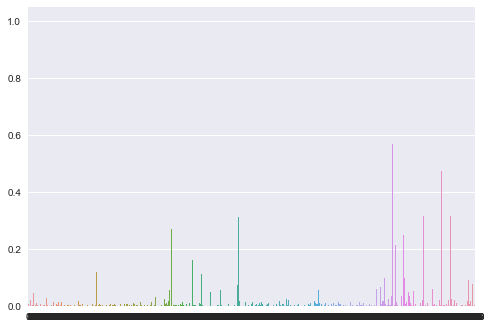

In [95]:
#using Seaborn
sns.set_context("notebook")
ax = sns.barplot(x=indices,y=importance_norm[indices])
plt.figure(figsize=(8,6))

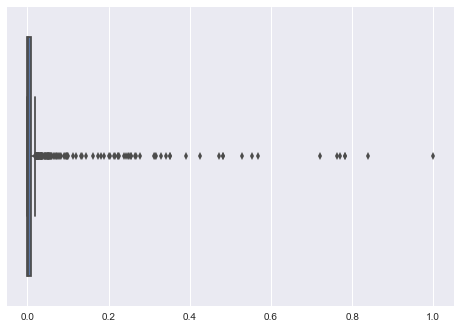

In [96]:
ax = sns.boxplot(importance_norm)
plt.figure(figsize=(8,6))

In [97]:
qc = np.percentile(importance_norm,[75])
print(1.5*qc)

[ 0.01155159]


In [98]:
# indmax = np.argwhere(importance_norm >= 1.5*qc)
indmax = np.argwhere(importance_norm >= 0.1)
indmax = indmax.reshape(-1)
print(len(indmax))
print(indmax)

47
[ 183  184  185  338  344  386  387  388  423  445  470  492  520  569  570
  599  785  786  940  945  946  948  956  957  972  986  988  989  990  996
 1018 1046 1047 1048 1070 1071 1072 1120 1121 1122 1144 1145 1146 1147 1190
 1195 1200]


In [99]:
forest = RandomForestClassifier(n_estimators=50,random_state=10,warm_start=False)
forest.fit(Xtr[:,indmax],ytr)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=10,
            verbose=0, warm_start=False)

In [100]:
ypred = forest.predict(Xte[:,indmax])
yscore = forest.predict_proba(Xte[:,indmax])
yscore = yscore[:,1]

In [101]:
#acc = np.sum(ypred==yte)/len(ypred)
#print('Acc = %.3f')%acc
fprHA, tprHA, thresholdsHA = metrics.roc_curve(yte, yscore, pos_label=1)
roc_aucHA = auc(fprHA, tprHA)
print('AUC = %.3f'%roc_aucHA)

AUC = 0.991


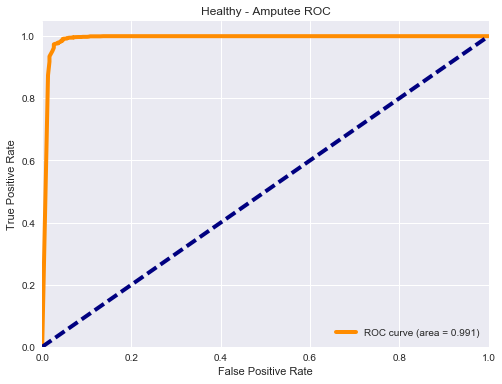

In [102]:
plt.figure(figsize=(8,6))
lw = 4
plt.plot(fprHA, tprHA, color='darkorange',
         lw=lw, label='ROC curve (area = %0.3f)' % roc_aucHA)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Healthy - Amputee ROC')
plt.legend(loc="lower right")
sns.set_context('poster')

### Threshold Method

In [103]:
Healthy = Healthy.rename(index=int,columns={950:'AccMax',951:'AccMin'})
Amp = Amp.rename(index=int,columns={950:'AccMax',951:'AccMin'})
[Sens, Spec] = ThresholdClass(Healthy,Amp)

In [104]:
print (Sens)
print (Spec)

1.0
0.18892508143322476


# LOSO CV on Healthy

In [105]:
Healthy = pd.read_csv('./Data/Healthy10.csv',header=None)
Healthy = Healthy.rename(index=int, columns={0:'SubjID',1:'Loc',2:'Subjtype',3:'Falltype',950:'AccMax',951:'AccMin'})

In [106]:
from sklearn.model_selection import LeaveOneGroupOut

In [107]:
#Subjects with indoor and outdoor falls
print(np.sort(Healthy[Healthy.Subjtype == 1].SubjID.unique()))
print(np.sort(Healthy[Healthy.Subjtype == 2].SubjID.unique()))

[ 1  2  3  4  5  6  7  8  9 10]
[ 1  2  4  5  6  7  8  9 10]


In [108]:
#drop subject 3 
Healthy = Healthy[Healthy.SubjID!=3]
Healthy.SubjID.unique()

array([ 1,  2,  4,  5,  6,  7,  8,  9, 10], dtype=int64)

In [109]:
Healthy.shape

(6236, 1215)

In [110]:
#binarize labels
X = Healthy.iloc[:,4:].as_matrix()
y = Healthy.Falltype.as_matrix()
y[y < 9] = 1
y[y == 9] = 0

In [111]:
np.unique(y)

array([0, 1], dtype=int64)

In [112]:
print(X.shape)
print(y.shape)

(6236, 1211)
(6236,)


In [113]:
groups = Healthy.SubjID.as_matrix()
print(groups.shape)
print(np.unique(groups))

(6236,)
[ 1  2  4  5  6  7  8  9 10]


In [114]:
subj = LeaveOneGroupOut()
subj.get_n_splits(X,y,groups)

9

In [115]:
indmax #602 gyro features + 602 accelerometer

array([ 183,  184,  185,  338,  344,  386,  387,  388,  423,  445,  470,
        492,  520,  569,  570,  599,  785,  786,  940,  945,  946,  948,
        956,  957,  972,  986,  988,  989,  990,  996, 1018, 1046, 1047,
       1048, 1070, 1071, 1072, 1120, 1121, 1122, 1144, 1145, 1146, 1147,
       1190, 1195, 1200], dtype=int64)

In [116]:
## Use Magnitude Features Only
indmax = np.linspace(336,355,20)
indmax = np.hstack([indmax,np.linspace(336,355,20)+602])
indmax = indmax.astype(int)

In [117]:
#sanity check
for train_index, test_index in subj.split(X, y, groups):
    Xtr,Xte = X[train_index],X[test_index]
    ytr = y[train_index]
    Xtr,Xte = Xtr[:,indmax],Xte[:,indmax]
    print(Xtr.shape,Xte.shape,ytr.shape)

(5540, 40) (696, 40) (5540,)
(5549, 40) (687, 40) (5549,)
(5680, 40) (556, 40) (5680,)
(5504, 40) (732, 40) (5504,)
(5502, 40) (734, 40) (5502,)
(5529, 40) (707, 40) (5529,)
(5614, 40) (622, 40) (5614,)
(5460, 40) (776, 40) (5460,)
(5510, 40) (726, 40) (5510,)


In [118]:
print(Healthy.shape)
print(X.shape)

(6236, 1215)
(6236, 1211)


In [119]:
AUC_all_HH, fpr_all_HH, tpr_all_HH, Sens_all_HH, Spec_all_HH, TTPR_all_HH, TFPR_all_HH = LOSOCV(X,y,Healthy)

AUC = 0.9971, Sens = 1.0000, Spec = 0.9583
AUC = 0.9853, Sens = 0.9702, Spec = 0.8000
AUC = 1.0000, Sens = 1.0000, Spec = 1.0000
AUC = 1.0000, Sens = 1.0000, Spec = 1.0000
AUC = 0.9983, Sens = 0.9928, Spec = 0.8286
AUC = 1.0000, Sens = 0.9882, Spec = 1.0000
AUC = 0.9994, Sens = 0.9831, Spec = 1.0000
AUC = 0.9674, Sens = 0.9858, Spec = 0.8219
AUC = 0.9734, Sens = 0.9812, Spec = 0.9167
mean AUC = 0.991 (+/- 0.024)
mean Sens = 0.989 (+/- 0.019)
mean Spec = 0.925 (+/- 0.162)


In [120]:
TTPR_all_HH = np.asarray(TTPR_all_HH)
TFPR_all_HH = np.asarray(TFPR_all_HH)

tprmuHH = np.mean(TTPR_all_HH)
tprerrHH = np.std(TTPR_all_HH)/math.sqrt(len(TTPR_all_HH))*1.96
fprmuHH = np.mean(TFPR_all_HH)
fprerrHH = np.std(TFPR_all_HH)/math.sqrt(len(TFPR_all_HH))*1.96

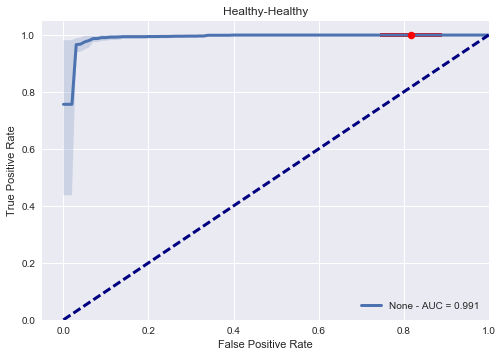

In [121]:
sns.set_context('notebook')
AX = None
AX = plot_roc(tpr_all_HH,fpr_all_HH,np.mean(AUC_all_HH))
AX.errorbar(fprmuHH,tprmuHH,xerr = fprerrHH,yerr = tprerrHH, ecolor = 'r',marker='.',mec='r',mfc='r',ms=15,lw=4)
AX.set_title('Healthy-Healthy')

In [122]:
HX = X
Hy = y

# LOSO CV on Amputees

**Note: SubjID 2 does not have activities** (Nick please check)
**Need to load each time the file because after binarizing the labels in previous steps the original table are changed. Should be fixed**

In [123]:
Amp = pd.read_csv('./Data/Amp10.csv',header=None)
Amp = Amp.rename(index=int, columns={0:'SubjID',1:'Loc',2:'Subjtype',3:'Falltype', 950:'AccMax',951:'AccMin'})

In [124]:
Amp[Amp.SubjID ==2].Falltype.unique()

array([4, 3, 2, 1], dtype=int64)

In [125]:
Amp = Amp[Amp.SubjID != 2] #drop subj 2

In [126]:
X = Amp.iloc[:,4:].as_matrix()
y = Amp.Falltype.as_matrix()
y[y < 9] = 1
y[y == 9] = 0
groups = Amp.SubjID.as_matrix()
print(groups.shape)
print(np.sort(np.unique(groups)))
subj = LeaveOneGroupOut()
subj.get_n_splits(X,y,groups)

(1840,)
[1 3 4 5 6 7]


6

In [127]:
groups = Amp.SubjID.as_matrix()
print(groups.shape)
print(np.unique(groups))
subj = LeaveOneGroupOut()
subj.get_n_splits(X,y,groups)

(1840,)
[1 3 4 5 6 7]


6

In [128]:
#sanity check
for train_index, test_index in subj.split(X, y, groups):
    Xtr,Xte = X[train_index],X[test_index]
    ytr = y[train_index]
    Xtr,Xte = Xtr[:,indmax],Xte[:,indmax]
    print(Xtr.shape,Xte.shape,ytr.shape)

(1578, 40) (262, 40) (1578,)
(1431, 40) (409, 40) (1431,)
(1446, 40) (394, 40) (1446,)
(1569, 40) (271, 40) (1569,)
(1732, 40) (108, 40) (1732,)
(1444, 40) (396, 40) (1444,)


In [129]:
AUC_all_AA, fpr_all_AA, tpr_all_AA, Sens_all_AA, Spec_all_AA, TTPR_allAA, TFPR_allAA = LOSOCV(X,y,Amp)

AUC = 0.9928, Sens = 0.9327, Spec = 0.9231
AUC = 0.9940, Sens = 1.0000, Spec = 0.9206
AUC = 0.9999, Sens = 0.9943, Spec = 1.0000
AUC = 0.9880, Sens = 0.9860, Spec = 0.8571
AUC = 0.9920, Sens = 0.8333, Spec = 1.0000
AUC = 0.9988, Sens = 1.0000, Spec = 0.9688
mean AUC = 0.994 (+/- 0.008)
mean Sens = 0.958 (+/- 0.121)
mean Spec = 0.945 (+/- 0.101)


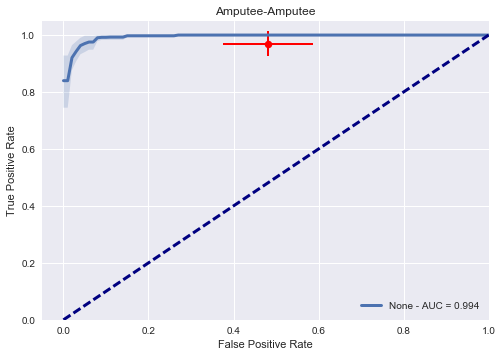

In [130]:
TTPR_allAA = np.asarray(TTPR_allAA)
TFPR_allAA = np.asarray(TFPR_allAA)

tprmuAA = np.mean(TTPR_allAA)
tprerrAA = np.std(TTPR_allAA)/math.sqrt(len(TTPR_allAA))*1.96
fprmuAA = np.mean(TFPR_allAA)
fprerrAA = np.std(TFPR_allAA)/math.sqrt(len(TFPR_allAA))*1.96

AX = plot_roc(tpr_all_AA,fpr_all_AA,np.mean(AUC_all_AA))
AX.errorbar(fprmuAA,tprmuAA,xerr = fprerrAA,yerr = tprerrAA, ecolor = 'r',marker='.',mec='r',mfc='r',ms=15,lw=2)
AX.set_title('Amputee-Amputee')

# Healthy to Amputee w/ folds 

In [131]:
AUC_all_HA, fpr_all_HA, tpr_all_HA, Sens_all_HA, Spec_all_HA, TTPR_allHA, TFPR_allHA = EvaluateBySubject(HX,Hy,Healthy,X,y,Amp)

AUC = 0.9945, Sens = 0.9910, Spec = 0.9231
AUC = 0.9821, Sens = 1.0000, Spec = 0.8889
AUC = 1.0000, Sens = 1.0000, Spec = 0.9535
AUC = 0.9778, Sens = 1.0000, Spec = 0.8036
AUC = 0.9806, Sens = 0.9091, Spec = 0.9048
AUC = 0.9998, Sens = 1.0000, Spec = 0.9531
mean AUC = 0.989 (+/- 0.018)
mean Sens = 0.983 (+/- 0.067)
mean Spec = 0.904 (+/- 0.102)


(0.1, 1.1)

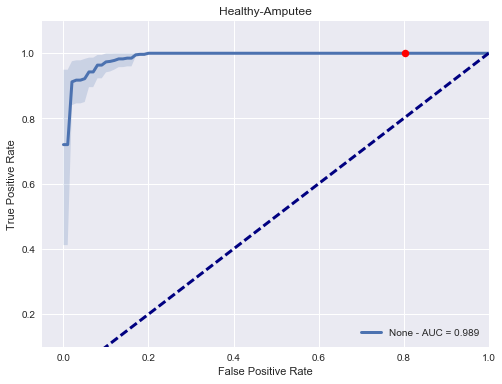

In [132]:
TTPR_allHA = np.asarray(TTPR_allHA)
TFPR_allHA = np.asarray(TFPR_allHA)

tprmuHA = np.mean(TTPR_allHA)
tprerrHA = np.std(TTPR_allHA)/math.sqrt(len(TTPR_allHA))*1.96
fprmuHA = np.mean(TFPR_allHA)
fprerrHA = np.std(TFPR_allHA)/math.sqrt(len(TFPR_allHA))*1.96

plt.figure(figsize=(8,6))
AX = plot_roc(tpr_all_HA,fpr_all_HA,np.mean(AUC_all_HA))
AX.errorbar(fprmuHA,tprmuHA,xerr = fprerrHA,yerr = tprerrHA, ecolor = 'r',marker='.',mec='r',mfc='r',ms=15,lw=2)
AX.set_title('Healthy-Amputee')
plt.ylim([0.1,1.1])

In [133]:
dataroc= [[tpr_all_HH,fpr_all_HH,AUC_all_HH,fprmuHH,tprmuHH,fprerrHH,tprerrHH],
          [tpr_all_HA,fpr_all_HA,AUC_all_HA,fprmuHA,tprmuHA,fprerrHA,tprerrHA],
          [tpr_all_AA,fpr_all_AA,AUC_all_AA,fprmuAA,tprmuAA,fprerrAA,tprerrAA]]

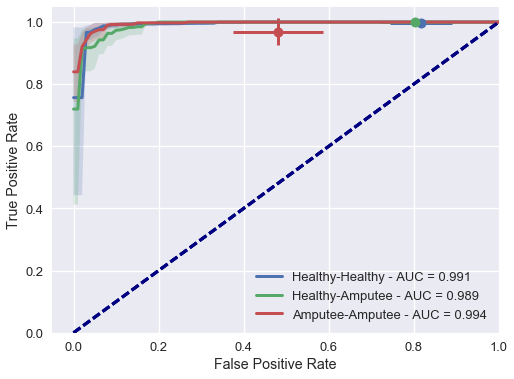

In [134]:
AX.errorbar(fprmuAA,tprmuAA,xerr = fprerrAA,yerr = tprerrAA, ecolor = 'r',marker='.',mec='r',mfc='r',ms=15,lw=2)


population = ['Healthy-Healthy','Healthy-Amputee','Amputee-Amputee']
fig = plt.figure(figsize=(8,6))
ax1=None
sns.set_context('talk')
for index,value in enumerate(population):
    ax1 = plot_roc(dataroc[index][0],dataroc[index][1],np.mean(dataroc[index][2]),plotname=value,col=current_palette[index],ax=ax1)
    ax1.errorbar(dataroc[index][3],dataroc[index][4],xerr = dataroc[index][5],yerr = dataroc[index][6], ecolor = current_palette[index],
                 marker='.',mec=current_palette[index],mfc=current_palette[index],ms=20,lw=3)

# Location Analysis

## Waist, Pocket and Hand

AUC = 0.9032, Sens = 0.9283, Spec = 0.6410
AUC = 0.9191, Sens = 0.9277, Spec = 0.8095
AUC = 0.9902, Sens = 1.0000, Spec = 0.8837
AUC = 0.8822, Sens = 0.9442, Spec = 0.7321
AUC = 0.9899, Sens = 0.9848, Spec = 0.8810
AUC = 0.9319, Sens = 0.9307, Spec = 0.5781
mean AUC = 0.936 (+/- 0.082)
mean Sens = 0.953 (+/- 0.058)
mean Spec = 0.754 (+/- 0.231)
AUC = 0.9732, Sens = 0.9148, Spec = 0.8718
AUC = 0.9674, Sens = 0.9566, Spec = 0.8730
AUC = 0.9898, Sens = 0.9915, Spec = 0.9070
AUC = 0.9290, Sens = 0.9814, Spec = 0.8036
AUC = 0.9724, Sens = 0.9242, Spec = 0.7857
AUC = 0.9748, Sens = 0.9608, Spec = 0.8438
mean AUC = 0.968 (+/- 0.037)
mean Sens = 0.955 (+/- 0.056)
mean Spec = 0.847 (+/- 0.084)
AUC = 0.9685, Sens = 0.8161, Spec = 0.9231
AUC = 0.9978, Sens = 0.9682, Spec = 0.9683
AUC = 1.0000, Sens = 0.9430, Spec = 1.0000
AUC = 0.9224, Sens = 0.7814, Spec = 0.8571
AUC = 0.9273, Sens = 0.5909, Spec = 1.0000
AUC = 0.9889, Sens = 0.8886, Spec = 0.9844
mean AUC = 0.967 (+/- 0.064)
mean Sens = 0.831 (

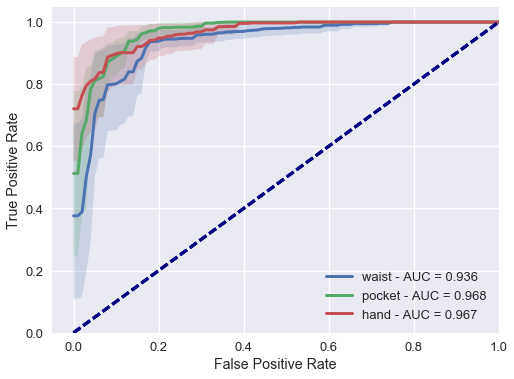

In [135]:
current_palette = sns.color_palette()
sns.set_context('talk')
locs = [1,2,3]
fig = plt.figure(figsize=(12,6))
ax1=None
for l,name in zip(locs,['waist','pocket','hand']):

    inds = Healthy.Loc==l
    Xloc = HX[np.asarray(inds)]
    yloc = Hy[np.asarray(inds)]
    Hdata = Healthy[Healthy.Loc==l]

    AUC_all_HA, fpr_all_HA, tpr_all_HA, Sens_all_HA, Spec_all_HA, TTPR_allHA, TFPR_allHA = EvaluateBySubject(Xloc,yloc,Healthy,X,y,Amp)

    TTPR_allHA = np.asarray(TTPR_allHA)
    TFPR_allHA = np.asarray(TFPR_allHA)

    tprmu = np.mean(TTPR_allHA)
    tprerr = np.std(TTPR_allHA)/math.sqrt(len(TTPR_allHA))*1.96
    fprmu = np.mean(TFPR_allHA)
    fprerr = np.std(TFPR_allHA)/math.sqrt(len(TFPR_allHA))*1.96
    
#     ax1 = fig.add_subplot(2,2,l) #uncomment this line to generate subplots
    ax1 = plot_roc(tpr_all_HA,fpr_all_HA,np.mean(AUC_all_HA),ax1,plotname=name,col=current_palette[l-1])
#     AX.errorbar(fprmu,tprmu,xerr = fprerr,yerr = tprerr, ecolor = 'r')


# Home data analysis

# Misc stuff to clean later

In [ ]:
AUC_all = []

plt.figure(figsize=(8,6))

for train_index, test_index in subj.split(X, y, groups):
    
    Xtr, Xte = X[train_index], X[test_index]
    ytr, yte = y[train_index], y[test_index]
    
    #selct features
    #Xtr, Xte = Xtr[:,indmax], Xte[:,indmax]
    
    forest = RandomForestClassifier(n_estimators=50,random_state=10,warm_start=False)    
    forest.fit(Xtr,ytr)
    ypred = forest.predict(Xte)
    yscore = forest.predict_proba(Xte)
    yscore = yscore[:,1]
    acc = np.sum(ypred==yte)/len(ypred)
    #print('Acc = %.4f')%acc
    fpr, tpr, thresholds = metrics.roc_curve(yte, yscore, pos_label=1)
    roc_auc = auc(fpr, tpr)
    print('AUC = %.4f'%roc_auc)    
    AUC_all.append(roc_auc)  
    
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Amputees - Random forest')
plt.legend(loc="lower right")

In [ ]:
#LOSO CV
AUC_all = []

plt.figure(figsize=(8,6))

for train_index, test_index in subj.split(X, y, groups):
    
    Xtr, Xte = X[train_index], X[test_index]
    ytr, yte = y[train_index], y[test_index]
    
    #selct features
    Xtr, Xte = Xtr[:,indmax], Xte[:,indmax]

    xgb1.fit(Xtr,ytr)
    ypred = xgb1.predict(Xte)
    yscore = xgb1.predict_proba(Xte)
    yscore = yscore[:,1]
    acc = np.sum(ypred==yte)/len(ypred)
#    print('Acc = %.4f')%acc
    fpr, tpr, thresholds = metrics.roc_curve(yte, yscore, pos_label=1)
    roc_auc = auc(fpr, tpr)
    print('AUC = %.4f'%roc_auc)    
    AUC_all.append(roc_auc)  
    
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Healthy - XGboost forest')
plt.legend(loc="lower right")

In [ ]:
print('mean AUC = %.3f (+/- %0.3f)')%(np.mean(AUC_all),2*np.std(AUC_all))

See here on XGBoost params
http://xgboost.readthedocs.io/en/latest/parameter.html#general-parameters

as well as here
https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [ ]:
xgb1.get_params()

In [ ]:
xgb1.fit(Xtr,ytr,eval_metric='auc')

In [ ]:
pred = xgb1.predict(Xte)

In [ ]:
pred_prob = xgb1.predict_proba(Xte)

In [ ]:
pred_prob.shape

In [ ]:
X = Xin.drop(['SubjID','Loc','Subjtype'],axis=1)
X.head(3)

In [ ]:
xgtrain = xgb.DMatrix(X,label='Falltype')
xgtest = xgb.DMatrix(Xte,label='Falltype')

In [ ]:
print xgtrain.num_col()
print xgtrain.num_row()
print xgtest.num_col()
print xgtest.num_row()

Look at the clips

In [ ]:
labels = sio.loadmat('./Data/accHealthy10.mat')

In [ ]:
acc = labels['acc']

In [ ]:
acc.shape

In [ ]:
i

In [ ]:
i = np.random.permutation(fpidx4)
i = i[0]
a = acc[i][0][:,1:]
plt.plot(a)

In [ ]:
np.where(Healthy.Falltype == 0)

In [ ]:
acc